# Transfer Learning with TensorFlow Part 3: Scaling up (Food Vision mini)

We've seen the power of transfer learning feature extraction and fine-tuning, now it's to scale up to all of the classes in Food101 (101 total classes of food).

Our goal is to beat the original Food101 paper with 10% of the training data (leveraging the power of deep learning).

Original Food101 paper: chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf

Our baseline to beat is 50.76% accuracy across 101 classes.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Check GPU
!nvidia-smi

Thu May 11 15:17:36 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Creating helper functions

In previous notebooks, we've created a series of helper functions to do different tasks, let's download them.

In [ ]:
!wget https://raw.githubusercontent.com/JoachimLombardi/Helper_functions/master/course_ztm.py

--2023-05-11 15:17:41--  https://raw.githubusercontent.com/JoachimLombardi/Helper_functions/master/course_ztm.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘course_ztm.py’

course_ztm.py       100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-05-11 15:17:41 (65.4 MB/s) - ‘course_ztm.py’ saved [10246/10246]



In [ ]:
# Import series of helper functions for our notebook
from course_ztm import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

## 101 Food Classes: working with less data

Our goal is to beat the original Food101 paper with 10% of the training data, so let's download it.

The data we're downloading comes from this original Food101 dataset but has been preprocessed using the image_data_modification notebook - https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/image_data_modification.ipynb

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
unzip_data("101_food_classes_10_percent.zip")

train_dir = "101_food_classes_10_percent/train"
test_dir = "101_food_classes_10_percent/test"

--2023-05-11 15:17:58--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.153.128, 142.250.145.128, 173.194.69.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.153.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G  38.7MB/s    in 52s     

2023-05-11 15:18:51 (29.9 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [ ]:
# How many images/classes are there ?
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/test'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/baklava'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/tiramisu'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/waffles'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/oysters'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/caprese_salad'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/chocolate_cake'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/chicken_quesadilla'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/cannoli'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/miso_soup'.
There are 0 directories and 250 images in '101_foo

In [ ]:
# Setup our data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode="categorical",
                                                                                image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False) # don't shuffle for prediction analysis, to keep the order.

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Train a big dog model with transfer learning on 10% of 101 food classes

Here are the steps we're going to take:
* Create a ModelCheckpoint callback
* Create a data augmentation layer to build data augmentation right into the model
* Build a headless (no top layers) Functional EfficientNetB0 back-boned model (we'll create our own output layer)
* Compile our model
* Feature extract for 5 full passes (5 epochs on the train dataset and validate on 15% of the test data, to save epoch time)

In [ ]:
# Create checkpoint callback
checkpoint_path = "drive/MyDrive/101_classes_food/101_classes_10_percent_data_model_checkpoint"
def create_checkpoint(checkpoint_path=checkpoint_path):
  checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                          save_weights_only=True,
                                                          monitor="val_accuracy",
                                                          save_best_only=True) # Save only the weights that achieve the highest accuracy
  return checkpoint_callback

In [ ]:
# Create a data augmentation layer to incorporate it right into the model
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import Sequential

# Setup data augmentation
data_augmentation = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),
    # preprocessing.Rescale(1/255.) # Resnet50
],name="data_augmentation")

In [ ]:
# Setup the base model and freeze its layers (this will extract features)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Setup model architecture with trainable top layers
inputs = layers.Input(shape=(224, 224, 3), name="input_layer")
x = data_augmentation(inputs)
x = base_model(x, training=False) # Put the base model in inference mode so weights need to stay frozen
x = layers.GlobalAveragePooling2D(name="global_avg_pool_layer")(x)
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation="softmax", name="output_layer")(x)
model = tf.keras.Model(inputs, outputs)

16705208/16705208 [==============================] - 0s 0us/step


In [ ]:
# Get a summary of model we've created
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_avg_pool_layer (Glob  (None, 1280)             0         
 alAveragePooling2D)                                             
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [ ]:
# Compile the model
model.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
  
# Fit the model and save its history
history_101_classes_10_percent = model.fit(train_data_all_10_percent,
                      epochs=5,
                      steps_per_epoch=len(train_data_all_10_percent),
                      validation_data=test_data,
                      validation_steps=int(0.15 * len(test_data)),
                      callbacks=[create_checkpoint()])

Epoch 1/5
237/237 [==============================] - 116s 425ms/step - loss: 3.3561 - accuracy: 0.2762 - val_loss: 2.5423 - val_accuracy: 0.4407
Epoch 2/5
237/237 [==============================] - 74s 305ms/step - loss: 2.1928 - accuracy: 0.4997 - val_loss: 2.0730 - val_accuracy: 0.5058
Epoch 3/5
237/237 [==============================] - 66s 274ms/step - loss: 1.8198 - accuracy: 0.5595 - val_loss: 1.9579 - val_accuracy: 0.5050
Epoch 4/5
237/237 [==============================] - 58s 242ms/step - loss: 1.5956 - accuracy: 0.6158 - val_loss: 1.8246 - val_accuracy: 0.5318
Epoch 5/5
237/237 [==============================] - 55s 231ms/step - loss: 1.4547 - accuracy: 0.6424 - val_loss: 1.7751 - val_accuracy: 0.5339


In [ ]:
# Evaluate on the whole test dataset
fine_tuning_results = model.evaluate(test_data)
fine_tuning_results

790/790 [==============================] - 64s 81ms/step - loss: 1.5777 - accuracy: 0.5851


[1.5777167081832886, 0.5851089358329773]

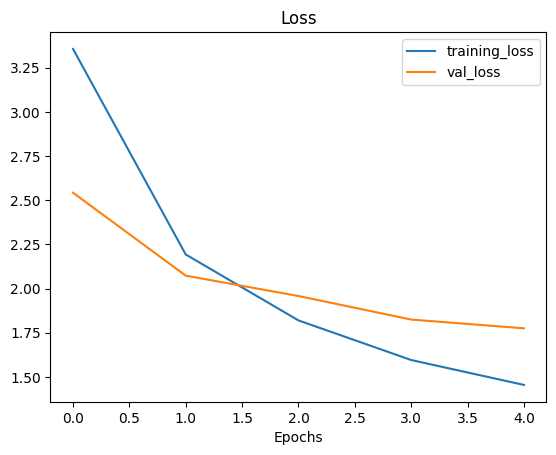

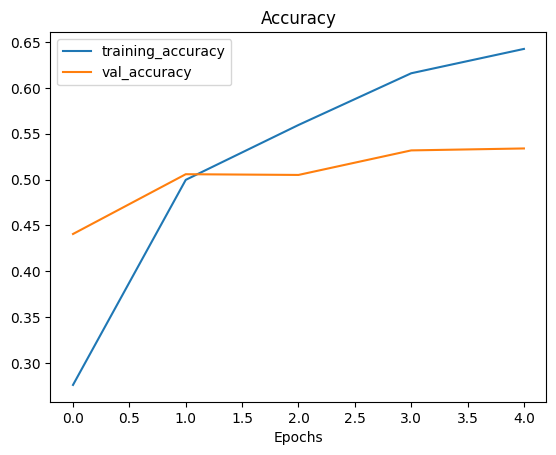

In [ ]:
plot_loss_curves(history_101_classes_10_percent)

> 🤔 **Qestion:** What do these curves suggest ? Hint: ideally, the two curves should be very similar to each other, if not it may suggest overfitting.

## Fine-tuning

In [ ]:
# Unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze every layers except the last 5
for layer in base_model.layers[:-5]:
  layer.trainable=False

In [ ]:
# Recompile (we have to recompile our models every time we make a change)
model.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # learning rate dictate how much your model patterns should update to try improve the loss functions
                metrics=["accuracy"])

In [ ]:
# What layers in the model are trainable ?
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
global_avg_pool_layer True
output_layer True


In [ ]:
# Check which layers are trainable in our base model
for layer_number, layer in enumerate(model.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 rescaling_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze False
39

In [ ]:
initial_epoch = 5

In [ ]:
# Continue to train and fit the model to our data  
fine_tune_epochs = initial_epoch + 5
history_fine_101_classes_10_percent_5_epochs = model.fit(train_data_all_10_percent,
                                                         epochs=fine_tune_epochs,
                                                         validation_data=test_data,
                                                         validation_steps=int(0.15 * len(test_data)),
                                                         initial_epoch=history_101_classes_10_percent.epoch[-1], 
                                                         callbacks=[create_tensorboard_callback(dir_name="drive/MyDrive/101_classes_food/transfer_learning", 
                                                                                                experiment_name="101_classes_10_percent_fine_tuning_5_epochs")]) #Start training from previous last epoch

Saving TensorBoard log files to: drive/MyDrive/101_classes_food/transfer_learning/101_classes_10_percent_fine_tuning_5_epochs/20230510-093751
Epoch 5/10
237/237 [==============================] - 68s 241ms/step - loss: 1.2108 - accuracy: 0.6850 - val_loss: 1.7293 - val_accuracy: 0.5355
Epoch 6/10
237/237 [==============================] - 55s 231ms/step - loss: 1.0884 - accuracy: 0.7097 - val_loss: 1.7364 - val_accuracy: 0.5408
Epoch 7/10
237/237 [==============================] - 50s 210ms/step - loss: 1.0174 - accuracy: 0.7267 - val_loss: 1.6762 - val_accuracy: 0.5527
Epoch 8/10
237/237 [==============================] - 46s 192ms/step - loss: 0.9451 - accuracy: 0.7483 - val_loss: 1.7266 - val_accuracy: 0.5424
Epoch 9/10
237/237 [==============================] - 42s 177ms/step - loss: 0.8824 - accuracy: 0.7698 - val_loss: 1.7419 - val_accuracy: 0.5408
Epoch 10/10
237/237 [==============================] - 46s 193ms/step - loss: 0.8268 - accuracy: 0.7799 - val_loss: 1.6875 - val_accu

In [ ]:
# Evaluate on the whole test dataset
fine_tuning_results_ = model.evaluate(test_data)
fine_tuning_results_

790/790 [==============================] - 61s 77ms/step - loss: 1.4948 - accuracy: 0.6038


[1.4947988986968994, 0.6038416028022766]

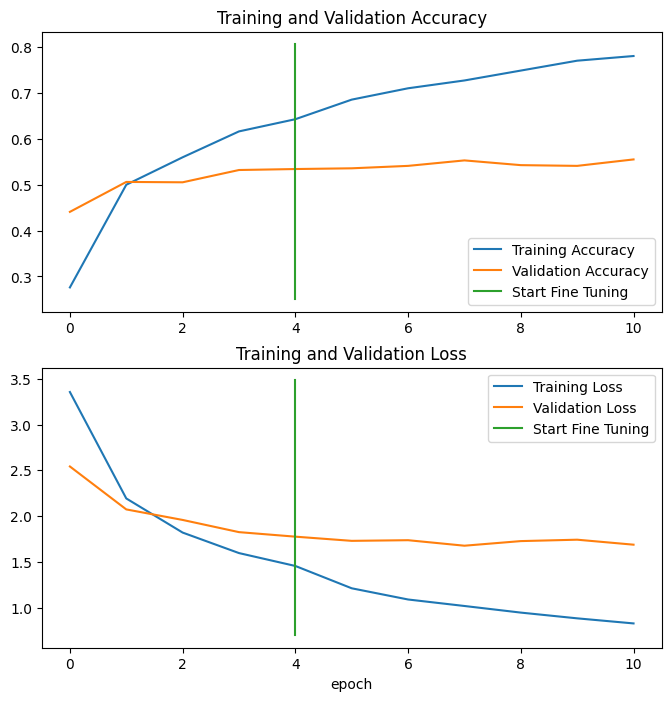

In [ ]:
# Compare the histories of feature exctration and fine tuning
compare_historys(history_101_classes_10_percent,
                 history_fine_101_classes_10_percent_5_epochs,
                 initial_epoch)

## Saving and reloading a trained model

In [ ]:
import os, datetime, pytz
# Create a function to save a model
def save_model(model, suffix=None):
  """
  Saves a given model in a models directory and appends a suffix (string).
  """
  # Create a model directory pathname with current time
  tz = pytz.timezone('Europe/Paris')
  modeldir = os.path.join("drive/MyDrive/101_classes_food/save",
                          datetime.datetime.now().astimezone(tz).strftime("%d%m%Y-%H%M%S"))
  model_path = modeldir + "-" + suffix + ".h5" # Save format of model
  print(f"Saving model to: {model_path}...")
  model.save(model_path)
  return model_path

In [ ]:
import tensorflow_hub as hub
# Create a function to load a trained model
def load_model(model_path):
  """
  Loads a saved model from a specified path.
  """
  print(f"Loading saved model from: {model_path}")
  model = tf.keras.models.load_model(model_path
                                     ) 
  return model

 For fine-tuning better to downgrade to tensorflow 2.8.3

In [ ]:
print(tf.__version__)

2.12.0


## Evaluating the performance of the big dog model across all different classes
Let's make some predictions, visaulize them and find out which predictions were the "most" wrong

In [ ]:
 import tensorflow as tf

 # Download pretrained model (one that was prepared earlier, so all predictions are similar)
 !wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip

--2023-05-11 07:18:39--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.6.128, 108.177.112.128, 74.125.124.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.6.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip’

06_101_food_class_1 100%[===================>]  44.59M  70.2MB/s    in 0.6s    

2023-05-11 07:18:40 (70.2 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip’ saved [46760742/46760742]



In [ ]:
 unzip_data("06_101_food_class_10_percent_saved_big_dog_model.zip")

🔑 **Note:** Loading the model with the following cell will output a large alount of warnings, there is a thread tracking this issue on GitHub: https://github.com/tensorflow/tensorflow/issues/40166, however, it seems according to the TensorFlow documentation, loading warnings can be ignored: https://www.tensorflow.org/tutorials/keras/save_and_load?hl=fr#save_checkpoints_during_training

In [ ]:
 # Load in saved model
 model = tf.keras.models.load_model("06_101_food_class_10_percent_saved_big_dog_model")

In [ ]:
 # Evaluate loaded model (the one we just downloaded on test data)

results_downloaded_model = model.evaluate(test_data)
results_downloaded_model  

790/790 [==============================] - 75s 82ms/step - loss: 1.8027 - accuracy: 0.6078


[1.8027206659317017, 0.6077623963356018]

## Making predictions with our trained model

In [ ]:
preds_probs = model.predict(test_data, verbose=1) # Set verbosity to see how long is left

790/790 [==============================] - 2208s 3s/step


In [ ]:
len(preds_probs)

25250

In [ ]:
df_preds = pd.DataFrame(preds_probs, columns=[f'prediction_{i}' for i in range(101)])
df_preds.to_csv('drive/MyDrive/101_classes_food/predictions/predictions.csv', index=False)

In [ ]:
import pandas as pd
df_preds = pd.read_csv('drive/MyDrive/101_classes_food/predictions/predictions.csv')

In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()


''

In [ ]:
# How many predictions are there ?
len(preds_probs)

25250

In [ ]:
# What's the shape of our predictions ?
preds_probs.shape

(25250, 101)

In [ ]:
# Let's see what the first 10 predictions look like
preds_probs[:10]

array([[5.9541944e-02, 3.5742594e-06, 4.1377328e-02, ..., 1.4138719e-09,
        8.3531624e-05, 3.0897509e-03],
       [9.6401662e-01, 1.3753112e-09, 8.4779633e-04, ..., 5.4287142e-05,
        7.8361892e-12, 9.8465458e-10],
       [9.5925856e-01, 3.2533677e-05, 1.4867130e-03, ..., 7.1891736e-07,
        5.4396480e-07, 4.0275841e-05],
       ...,
       [4.7313458e-01, 1.2931262e-07, 1.4805597e-03, ..., 5.9750176e-04,
        6.6968991e-05, 2.3469260e-05],
       [4.4571634e-02, 4.7265630e-07, 1.2258522e-01, ..., 6.3499192e-06,
        7.5318326e-06, 3.6778755e-03],
       [7.2438973e-01, 1.9249884e-09, 5.2311050e-05, ..., 1.2291416e-03,
        1.5792809e-09, 9.6395401e-05]], dtype=float32)

In [ ]:
# What does the first prediction probability array look like
preds_probs[0]

array([5.95419444e-02, 3.57425938e-06, 4.13773283e-02, 1.06607478e-09,
       8.16160650e-09, 8.66405614e-09, 8.09279641e-07, 8.56528970e-07,
       1.98590715e-05, 8.09789185e-07, 3.17281956e-09, 9.86756163e-07,
       2.85325135e-04, 7.80501552e-10, 7.42300879e-04, 3.89167071e-05,
       6.47414799e-06, 2.49773507e-06, 3.78914920e-05, 2.06784435e-07,
       1.55387024e-05, 8.15070166e-07, 2.62306162e-06, 2.00108730e-07,
       8.38276890e-07, 5.42165481e-06, 3.73913872e-06, 1.31505207e-08,
       2.77614547e-03, 2.80516197e-05, 6.85633939e-10, 2.55750019e-05,
       1.66889440e-04, 7.64083741e-10, 4.04534920e-04, 1.31508200e-08,
       1.79575306e-06, 1.44483658e-06, 2.30632722e-02, 8.24678011e-07,
       8.53668212e-07, 1.71385943e-06, 7.05259708e-06, 1.84024991e-08,
       2.85538675e-07, 7.94832977e-06, 2.06820437e-06, 1.85253626e-07,
       3.36199939e-08, 3.15228215e-04, 1.04111014e-05, 8.54503980e-07,
       8.47417772e-01, 1.05555855e-05, 4.40947900e-07, 3.74048177e-05,
      

Our model outputs a prediction probability array (with N number of variables, where N is the number of classes) for each sample passed to the predict method.

In [ ]:
# We get one predictions probability per class (in our case there's 101 prediction probabilities)
print(f"Number of predictions probabilities for sample 0: {len(preds_probs[0])}")
print(f"What prediction probability sample 0 look like:\n {preds_probs[0]}")
print(f"The class with the highest predicted probability by the model for sample 0: {preds_probs[0].argmax()}")

Number of predictions probabilities for sample 0: 101
What prediction probability sample 0 look like:
 [5.95419444e-02 3.57425938e-06 4.13773283e-02 1.06607478e-09
 8.16160650e-09 8.66405614e-09 8.09279641e-07 8.56528970e-07
 1.98590715e-05 8.09789185e-07 3.17281956e-09 9.86756163e-07
 2.85325135e-04 7.80501552e-10 7.42300879e-04 3.89167071e-05
 6.47414799e-06 2.49773507e-06 3.78914920e-05 2.06784435e-07
 1.55387024e-05 8.15070166e-07 2.62306162e-06 2.00108730e-07
 8.38276890e-07 5.42165481e-06 3.73913872e-06 1.31505207e-08
 2.77614547e-03 2.80516197e-05 6.85633939e-10 2.55750019e-05
 1.66889440e-04 7.64083741e-10 4.04534920e-04 1.31508200e-08
 1.79575306e-06 1.44483658e-06 2.30632722e-02 8.24678011e-07
 8.53668212e-07 1.71385943e-06 7.05259708e-06 1.84024991e-08
 2.85538675e-07 7.94832977e-06 2.06820437e-06 1.85253626e-07
 3.36199939e-08 3.15228215e-04 1.04111014e-05 8.54503980e-07
 8.47417772e-01 1.05555855e-05 4.40947900e-07 3.74048177e-05
 3.53066971e-05 3.24893153e-05 6.73148024e-

In [ ]:
test_data.class_names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [ ]:
# Get the pred classes of each labels
pred_classes = preds_probs.argmax(axis=1)

# How do they look ?
pred_classes[:10]

array([52,  0,  0, 80, 79, 61, 29,  0, 85,  0])

In [ ]:
# How many pred classes do we have ?
len(pred_classes)

25250

Now we've got a predictions array of all of our model's predictions, to evaluate them, we need to compare them to the original test dataset labels.

In [ ]:
# To get our test labels we need to unravel our test_data BatchDataseta
y_labels = []
for image, label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())


In [ ]:
# # Make predictions
# test_predictions = []
# for test_image in test_images:
#   test_predictions.append(model.predict(tf.expand_dims(test_image, axis=0)))

In [ ]:
# test_predictions[:10]

## Evaluating our model's predictions

One way to check that our model's predicitions array is in the same order as our test labels arrays is to find the accuracy score. Here our accuracy score is 0.6077.

In [ ]:
# Let's try scikit learn's accuracy score function and see what it comes up with
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_true=y_labels,
                                  y_pred=pred_classes)
sklearn_accuracy

0.6077623762376237

In [ ]:
# Does this metric come close to our model's evaluate results
import numpy as np
np.isclose(results_downloaded_model, sklearn_accuracy)

NameError: ignored

## Let's get visual: making a confusion matrix 

In [ ]:
from course_ztm import make_confusion_matrix

In [ ]:
# Get a list of class names
class_names = test_data.class_names
class_names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [ ]:
# We need to make some changes to our make_confusion_matrix function to ensure the x_labels print vertically
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

In [ ]:
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes = class_names,
                      figsize=(250, 100),
                      text_size = 20,
                      savefig=True)

## Let's keep the evaluation train going, time for a classification report 

Scikit-learn has a helpful function for acquiring many different classification metrics per class (e.g. precision, recall and F-1) called [classification_report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html), let's try it out.

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true=y_labels,
                            y_pred=pred_classes))

              precision    recall  f1-score   support

           0       0.29      0.20      0.24       250
           1       0.51      0.69      0.59       250
           2       0.56      0.65      0.60       250
           3       0.74      0.53      0.62       250
           4       0.73      0.43      0.54       250
           5       0.34      0.54      0.42       250
           6       0.67      0.79      0.72       250
           7       0.82      0.76      0.79       250
           8       0.40      0.37      0.39       250
           9       0.62      0.44      0.51       250
          10       0.62      0.42      0.50       250
          11       0.84      0.49      0.62       250
          12       0.52      0.74      0.61       250
          13       0.56      0.60      0.58       250
          14       0.56      0.59      0.57       250
          15       0.44      0.32      0.37       250
          16       0.45      0.75      0.57       250
          17       0.37    

The numbers above give a great class-by-class evaluation of our model's predictions but with so many classes, they're quite hard to understand.

How about we create a visualization to get a better understanding ?

In [ ]:
# Get a dictionnary of the classification report
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)
classification_report_dict

{'0': {'precision': 0.29310344827586204,
  'recall': 0.204,
  'f1-score': 0.24056603773584903,
  'support': 250},
 '1': {'precision': 0.5088235294117647,
  'recall': 0.692,
  'f1-score': 0.5864406779661017,
  'support': 250},
 '2': {'precision': 0.5625,
  'recall': 0.648,
  'f1-score': 0.6022304832713754,
  'support': 250},
 '3': {'precision': 0.7415730337078652,
  'recall': 0.528,
  'f1-score': 0.616822429906542,
  'support': 250},
 '4': {'precision': 0.7346938775510204,
  'recall': 0.432,
  'f1-score': 0.544080604534005,
  'support': 250},
 '5': {'precision': 0.34177215189873417,
  'recall': 0.54,
  'f1-score': 0.41860465116279066,
  'support': 250},
 '6': {'precision': 0.6677966101694915,
  'recall': 0.788,
  'f1-score': 0.7229357798165138,
  'support': 250},
 '7': {'precision': 0.8197424892703863,
  'recall': 0.764,
  'f1-score': 0.7908902691511386,
  'support': 250},
 '8': {'precision': 0.4025974025974026,
  'recall': 0.372,
  'f1-score': 0.3866943866943867,
  'support': 250},
 '9

Let's plot all of our classes F1-scores...

In [ ]:
classification_report_dict["99"]["f1-score"]

0.35356200527704484

In [ ]:
# Create empty dictionnary
class_f1_scores = {}
# Loop through classification report dictionnary items
for k, v in classification_report_dict.items():
  if k == "accuracy": # stop once we get to accuracy key
    break
  else:
    # Add class names and f1-scores to new dictionnary
    class_f1_scores[class_names[int(k)]] = v["f1-score"]
class_f1_scores

{'apple_pie': 0.24056603773584903,
 'baby_back_ribs': 0.5864406779661017,
 'baklava': 0.6022304832713754,
 'beef_carpaccio': 0.616822429906542,
 'beef_tartare': 0.544080604534005,
 'beet_salad': 0.41860465116279066,
 'beignets': 0.7229357798165138,
 'bibimbap': 0.7908902691511386,
 'bread_pudding': 0.3866943866943867,
 'breakfast_burrito': 0.5117370892018779,
 'bruschetta': 0.5047619047619047,
 'caesar_salad': 0.6161616161616161,
 'cannoli': 0.6105610561056106,
 'caprese_salad': 0.5775193798449612,
 'carrot_cake': 0.574757281553398,
 'ceviche': 0.36744186046511623,
 'cheese_plate': 0.5654135338345864,
 'cheesecake': 0.42546063651591287,
 'chicken_curry': 0.5008403361344538,
 'chicken_quesadilla': 0.6411889596602972,
 'chicken_wings': 0.7123809523809523,
 'chocolate_cake': 0.45261669024045265,
 'chocolate_mousse': 0.3291592128801431,
 'churros': 0.7134935304990757,
 'clam_chowder': 0.7708779443254817,
 'club_sandwich': 0.734020618556701,
 'crab_cakes': 0.4625550660792952,
 'creme_brulee

In [ ]:
# Turns f1-scores into dataframe for visualization
import pandas as pd
f1_scores = pd.DataFrame({"class_names":list(class_f1_scores.keys()),
                         "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)

In [ ]:
f1_scores

class_names  f1-score
33              edamame  0.937143
63             macarons  0.895397
75                  pho  0.866538
91  spaghetti_carbonara  0.847656
69              oysters  0.834008
..                  ...       ...
56     huevos_rancheros  0.339833
22     chocolate_mousse  0.329159
77            pork_chop  0.308756
39            foie_gras  0.297491
0             apple_pie  0.240566

[101 rows x 2 columns]

(0.0, 0.984)

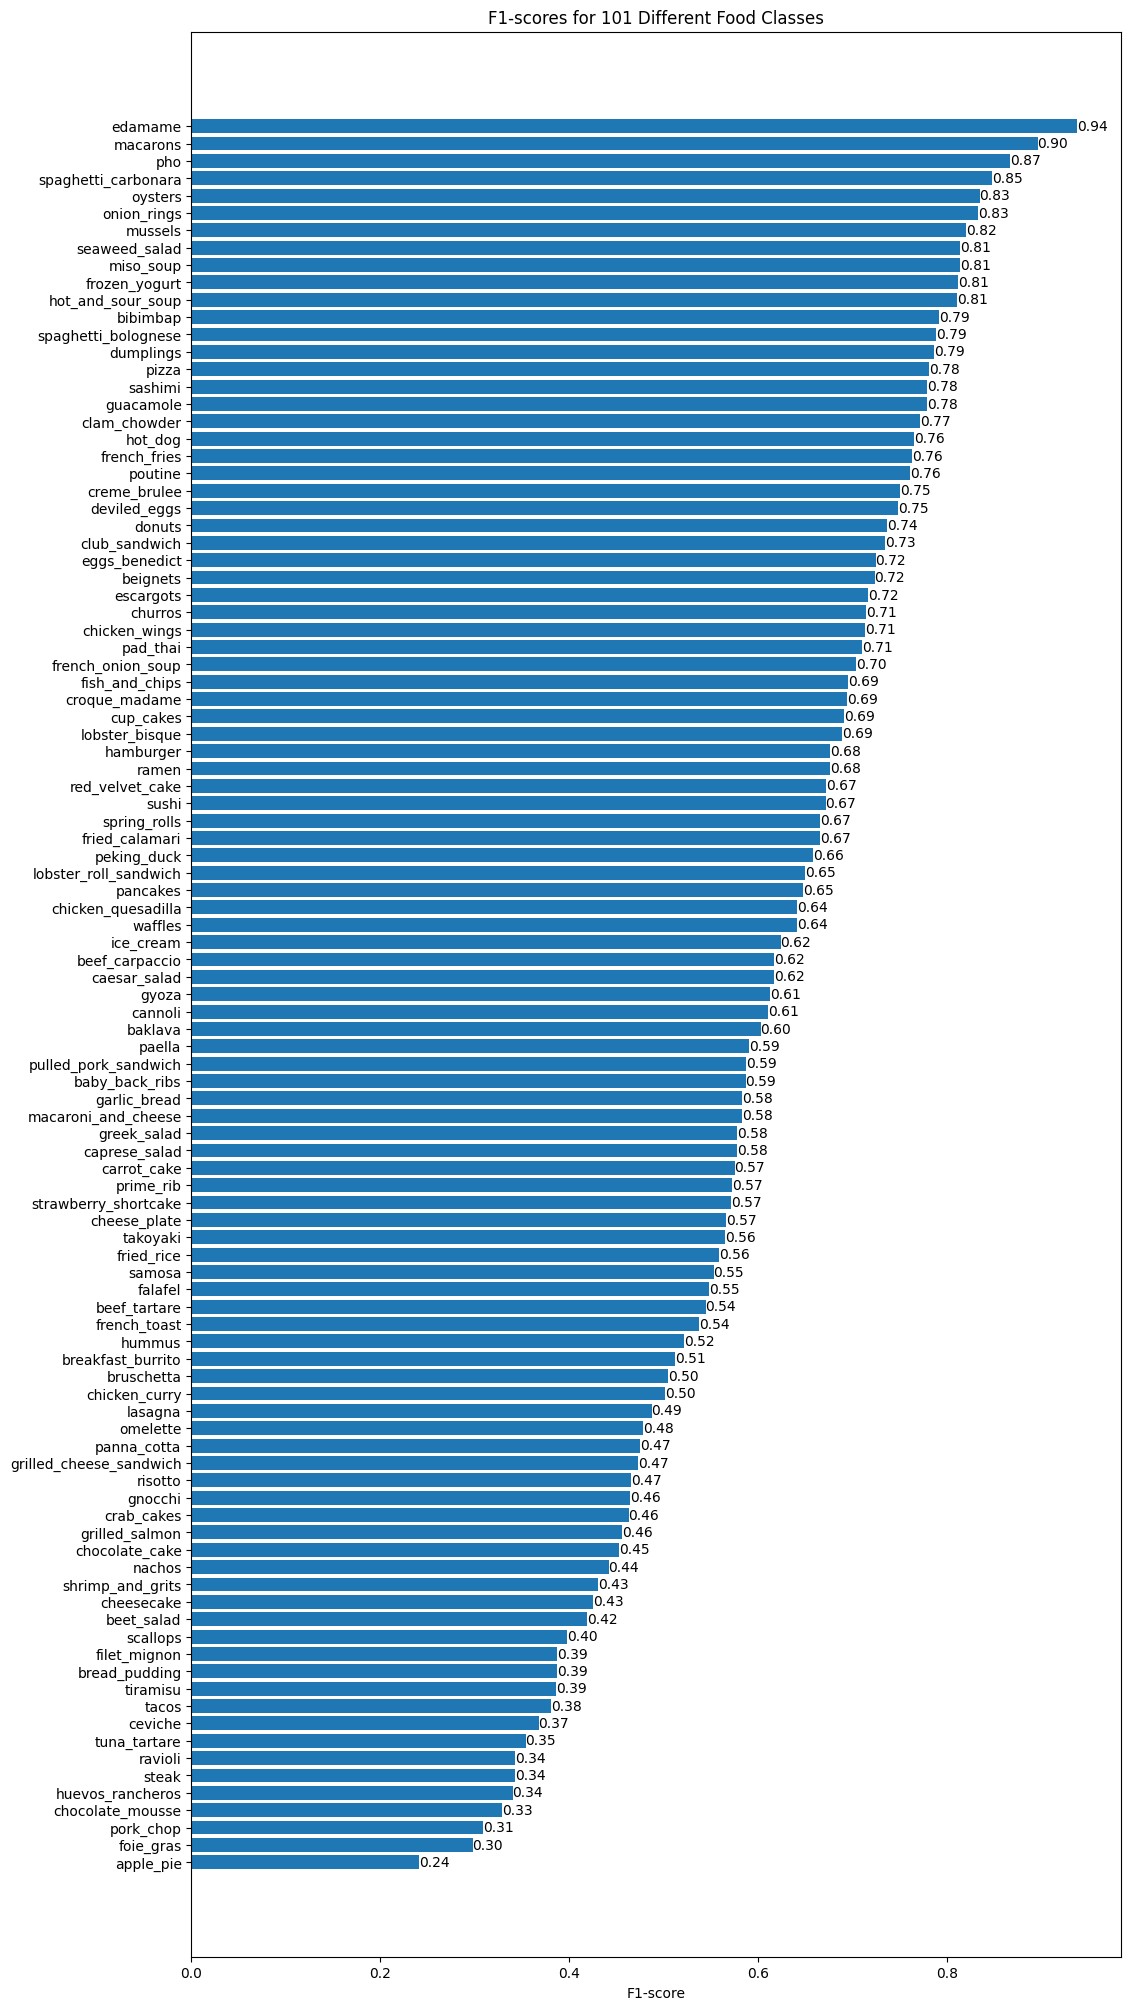

In [ ]:
fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values) # get f1-score values
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores["class_names"])
ax.set_xlabel("F1-score")
ax.set_title("F1-scores for 101 Different Food Classes")
ax.invert_yaxis(); # Reverse the order of our plot

# Challenge: add values to the end of each bar of what the actual f1-score is 
# (hint: use the "autolabel" function from here: https://matplotlib.org/stable/gallery/lines_bars_and_markers/bar_label_demo.html)

ax.bar_label(scores, fmt='%.2f')
ax.set_xlim() 

> 🛠 **Exercise:** Try visualizing some of the most poorly predicted classes (e.g `apple_pie`, `pork_chip`), do you notice any trends among them ? Why might our model be having trouble with them ?

## Visualizing predictions on test images 

Now, this is the real test, how does our model go on food images not even in our test dataset (images of our own, we'll see this later on). 

To visualize our model's predictions on our own images, we'll need a function to load and preprocess images, specifically it will need to: 
* Read in a target image filepath using tf.io.read_file()
* Turn the image into a Tensor tf.io.decode_image()
* Resize the image tensor to be the same size as the images our model has trained on using tf.image.resize()
* Scale the image to get all of the pixel values between 0 and 1 (if necessary)


In [ ]:
# Create a function to load and prepare images
def load_and_prep_image(filename, img_shape= 224, scale=True):
  """
  Read in an image from filename, turns it into a tensor and reshape into 
  specified shape (img_shape, img_shape, color_channel=3).

    Args:
      filename (str): path to target image
      image_shape (int): height/width dimension of target image size
      scale (bool): scale pixel values from 0-225 to 0-1 or not

    Returns:
      Image tensor of shape (img_shape, img_shape, 3)    
  """
  # Read in the image
  img = tf.io.read_file(filename)

  # Decode image into tensor
  img = tf.io.decode_image(img, channels=3) # if the image is a .PNG it will convert it from 4 channels to 3

  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])

   # Add one dim to fit our model shape
  img = tf.expand_dims(img, axis=0)
  
  # Scale ? Yes/No
  if scale:
    # Rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img # Don't need to for EfficientNet models in TensorFlow.

 

Now we've got a function to load and prepare target images, let's now write some code to visualize images, their target label and our model's predictions.

Specifically, we will write some code to:
1. Load a few random images from the test dataset
2. Make predictions on the loaded images
3. Plot the original image(s) with the model's predictions, prediction probability and truth label

In [ ]:
import os
import random

1/1 [==============================] - 0s 168ms/step


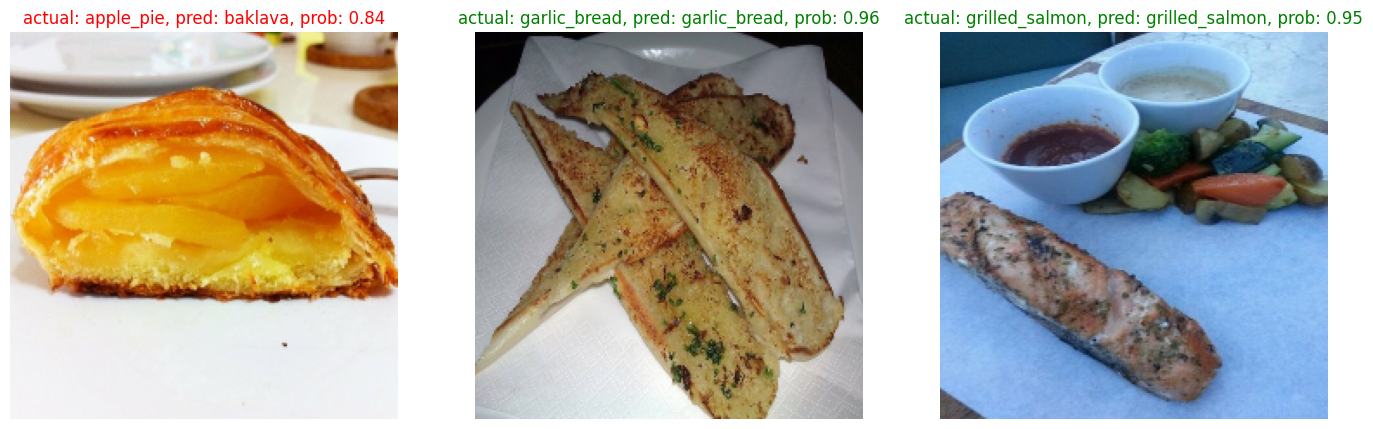

In [ ]:
# Make preds on a series of random images
plt.figure(figsize=(17, 10))
for i in range(3): 
  # Choose a random image from a random class
  class_name = random.choice(class_names) 
  filename = random.choice(os.listdir(test_dir + "/" + class_name))
  filepath = test_dir + "/" + class_name + "/" + filename

  # Load the image and make predictions
  img = load_and_prep_image(filepath, scale=False)
  pred_prob = model.predict(img) # get prediction probabilities array
  pred_class = class_names[pred_prob.argmax()] # get highest prediction probility index and match it to class_names list
  # print(pred_prob)
  # print(pred_class)

  # plot the images
  plt.subplot(1, 3, i+1)
  plt.imshow(tf.squeeze(img/255.))
  if class_name == pred_class: # if predicted class matches truth class, make test green
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
  plt.axis(False);

## Finding the most wrong predictions

To find out where our model is most wrong, let's write some code to find out the following:
1. Get all of the image file paths in the test dataset using list_files() method.
2. Create a Pandas DataFrame of the image filepaths, ground truth labels, predicted classes (from our model), max predictions probabilities, prediction class names, ground truth class names.
3. Use our DataFrame to find all the wrong predictions (where the ground thruth label doesn't match the prediction).
4. Sort the DataFrame based on wrong predictions (have the highest prediction probability predictions at the top).
5. Visualize the images with the highest prediction probabilities but have the wrong prediction. 

In [ ]:
# 1. Get all image filepath in test dataset
filepaths = []
for filepath in test_data.list_files("/content/101_food_classes_10_percent/test/*/*", shuffle=False):
  filepaths.append(filepath.numpy())
filepaths[:10]

[b'/content/101_food_classes_10_percent/test/apple_pie/1011328.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/101251.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1034399.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/103801.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1038694.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1047447.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1068632.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/110043.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1106961.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1113017.jpg']

In [ ]:
# 2 . Create pandas dataframe of differents parameters for each of our test images.
preds_df = pd.DataFrame({"imagepath":filepaths,
                         "y_true":y_labels,
                         "y_pred":pred_classes,
                         "pred_conf":preds_probs.max(axis=1), 
                         "y_true_classname":[class_names[i] for i in y_labels],
                         "y_pred_classname":[class_names[i] for i in pred_classes]})    
preds_df

NameError: ignored

In [ ]:
# 3. Find the wrong predictions

preds_df_wrong = preds_df[preds_df["y_true"] != preds_df["y_pred"]]
preds_df_wrong

imagepath  y_true  y_pred  \
0      b'101_food_classes_10_percent/test/apple_pie/1...       0      52   
3      b'101_food_classes_10_percent/test/apple_pie/1...       0      80   
4      b'101_food_classes_10_percent/test/apple_pie/1...       0      79   
5      b'101_food_classes_10_percent/test/apple_pie/1...       0      61   
6      b'101_food_classes_10_percent/test/apple_pie/1...       0      29   
...                                                  ...     ...     ...   
25234  b'101_food_classes_10_percent/test/waffles/863...     100      83   
25236  b'101_food_classes_10_percent/test/waffles/896...     100      22   
25243  b'101_food_classes_10_percent/test/waffles/913...     100      16   
25246  b'101_food_classes_10_percent/test/waffles/954...     100      16   
25248  b'101_food_classes_10_percent/test/waffles/970...     100      94   

       pred_conf y_true_classname       y_pred_classname  
0       0.847418        apple_pie                  gyoza  
3       0.658607        apple_pie   pulled_pork_sandwich  
4       0.367901        apple_pie              prime_rib  
5       0.456756        apple_pie  lobster_roll_sandwich  
6       0.611243        apple_pie              cup_cakes  
...          ...              ...                    ...  
25234   0.248724          waffles        red_velvet_cake  
25236   0.603934          waffles       chocolate_mousse  
25243   0.474088          waffles           cheese_plate  
25246   0.878028          waffles           cheese_plate  
25248   0.501945          waffles   strawberry_shortcake  

[9904 rows x 6 columns]

In [ ]:
# Sort by the highest probabilites at the top
preds_100_wrong = preds_df_wrong.sort_values("pred_conf", ascending=False)

In [ ]:
preds_100_wrong[:100]

imagepath  y_true  y_pred  \
21810  b'101_food_classes_10_percent/test/scallops/17...      87      29   
231    b'101_food_classes_10_percent/test/apple_pie/8...       0     100   
15359  b'101_food_classes_10_percent/test/lobster_rol...      61      53   
23539  b'101_food_classes_10_percent/test/strawberry_...      94      83   
21400  b'101_food_classes_10_percent/test/samosa/3140...      85      92   
...                                                  ...     ...     ...   
8763   b'101_food_classes_10_percent/test/escargots/1...      35      41   
2663   b'101_food_classes_10_percent/test/bruschetta/...      10      61   
7924   b'101_food_classes_10_percent/test/donuts/3454...      31      29   
18586  b'101_food_classes_10_percent/test/peking_duck...      74      39   
3519   b'101_food_classes_10_percent/test/carrot_cake...      14      21   

       pred_conf       y_true_classname       y_pred_classname  
21810   0.999997               scallops              cup_cakes  
231     0.999995              apple_pie                waffles  
15359   0.999988  lobster_roll_sandwich              hamburger  
23539   0.999987   strawberry_shortcake        red_velvet_cake  
21400   0.999981                 samosa           spring_rolls  
...          ...                    ...                    ...  
8763    0.997169              escargots      french_onion_soup  
2663    0.997055             bruschetta  lobster_roll_sandwich  
7924    0.997020                 donuts              cup_cakes  
18586   0.996884            peking_duck              foie_gras  
3519    0.996842            carrot_cake         chocolate_cake  

[100 rows x 6 columns]

In [ ]:
preds_100_wrong.to_csv("drive/MyDrive/101_classes_food/preds_100_wrong")

In [ ]:
preds_100_wrong = pd.read_csv("drive/MyDrive/101_classes_food/preds_100_wrong")
preds_100_wrong

Unnamed: 0                                          imagepath  y_true  \
0          21810  b'101_food_classes_10_percent/test/scallops/17...      87   
1            231  b'101_food_classes_10_percent/test/apple_pie/8...       0   
2          15359  b'101_food_classes_10_percent/test/lobster_rol...      61   
3          23539  b'101_food_classes_10_percent/test/strawberry_...      94   
4          21400  b'101_food_classes_10_percent/test/samosa/3140...      85   
...          ...                                                ...     ...   
9899       22303  b'101_food_classes_10_percent/test/shrimp_and_...      89   
9900       15646  b'101_food_classes_10_percent/test/macaroni_an...      62   
9901        6092  b'101_food_classes_10_percent/test/clam_chowde...      24   
9902         168  b'101_food_classes_10_percent/test/apple_pie/3...       0   
9903       11062  b'101_food_classes_10_percent/test/fried_rice/...      44   

      y_pred  pred_conf       y_true_classname      y_pred_classname  
0         29   0.999997               scallops             cup_cakes  
1        100   0.999995              apple_pie               waffles  
2         53   0.999988  lobster_roll_sandwich             hamburger  
3         83   0.999987   strawberry_shortcake       red_velvet_cake  
4         92   0.999981                 samosa          spring_rolls  
...      ...        ...                    ...                   ...  
9899      47   0.141997       shrimp_and_grits               gnocchi  
9900      19   0.139137    macaroni_and_cheese    chicken_quesadilla  
9901      16   0.137614           clam_chowder          cheese_plate  
9902      80   0.128813              apple_pie  pulled_pork_sandwich  
9903      97   0.126823             fried_rice              takoyaki  

[9904 rows x 7 columns]

In [ ]:
preds_100_wrong["imagepath"] = preds_100_wrong["imagepath"].str[2:-1]
preds_100_wrong

Unnamed: 0                                          imagepath  y_true  \
0          21810  101_food_classes_10_percent/test/scallops/1784...      87   
1            231  101_food_classes_10_percent/test/apple_pie/827...       0   
2          15359  101_food_classes_10_percent/test/lobster_roll_...      61   
3          23539  101_food_classes_10_percent/test/strawberry_sh...      94   
4          21400  101_food_classes_10_percent/test/samosa/314001...      85   
...          ...                                                ...     ...   
9899       22303  101_food_classes_10_percent/test/shrimp_and_gr...      89   
9900       15646  101_food_classes_10_percent/test/macaroni_and_...      62   
9901        6092  101_food_classes_10_percent/test/clam_chowder/...      24   
9902         168  101_food_classes_10_percent/test/apple_pie/343...       0   
9903       11062  101_food_classes_10_percent/test/fried_rice/17...      44   

      y_pred  pred_conf       y_true_classname      y_pred_classname  
0         29   0.999997               scallops             cup_cakes  
1        100   0.999995              apple_pie               waffles  
2         53   0.999988  lobster_roll_sandwich             hamburger  
3         83   0.999987   strawberry_shortcake       red_velvet_cake  
4         92   0.999981                 samosa          spring_rolls  
...      ...        ...                    ...                   ...  
9899      47   0.141997       shrimp_and_grits               gnocchi  
9900      19   0.139137    macaroni_and_cheese    chicken_quesadilla  
9901      16   0.137614           clam_chowder          cheese_plate  
9902      80   0.128813              apple_pie  pulled_pork_sandwich  
9903      97   0.126823             fried_rice              takoyaki  

[9904 rows x 7 columns]

In [ ]:
for i in preds_100_wrong["imagepath"].head(10):
  print(i)

101_food_classes_10_percent/test/scallops/1784196.jpg
101_food_classes_10_percent/test/apple_pie/827575.jpg
101_food_classes_10_percent/test/lobster_roll_sandwich/2325607.jpg
101_food_classes_10_percent/test/strawberry_shortcake/16590.jpg
101_food_classes_10_percent/test/samosa/3140015.jpg
101_food_classes_10_percent/test/tiramisu/1653292.jpg
101_food_classes_10_percent/test/bruschetta/1211650.jpg
101_food_classes_10_percent/test/chocolate_mousse/2048018.jpg
101_food_classes_10_percent/test/paella/2314464.jpg
101_food_classes_10_percent/test/sushi/1659357.jpg


In [ ]:
preds_100_wrong["y_pred_classname"].iloc[0]

'cup_cakes'

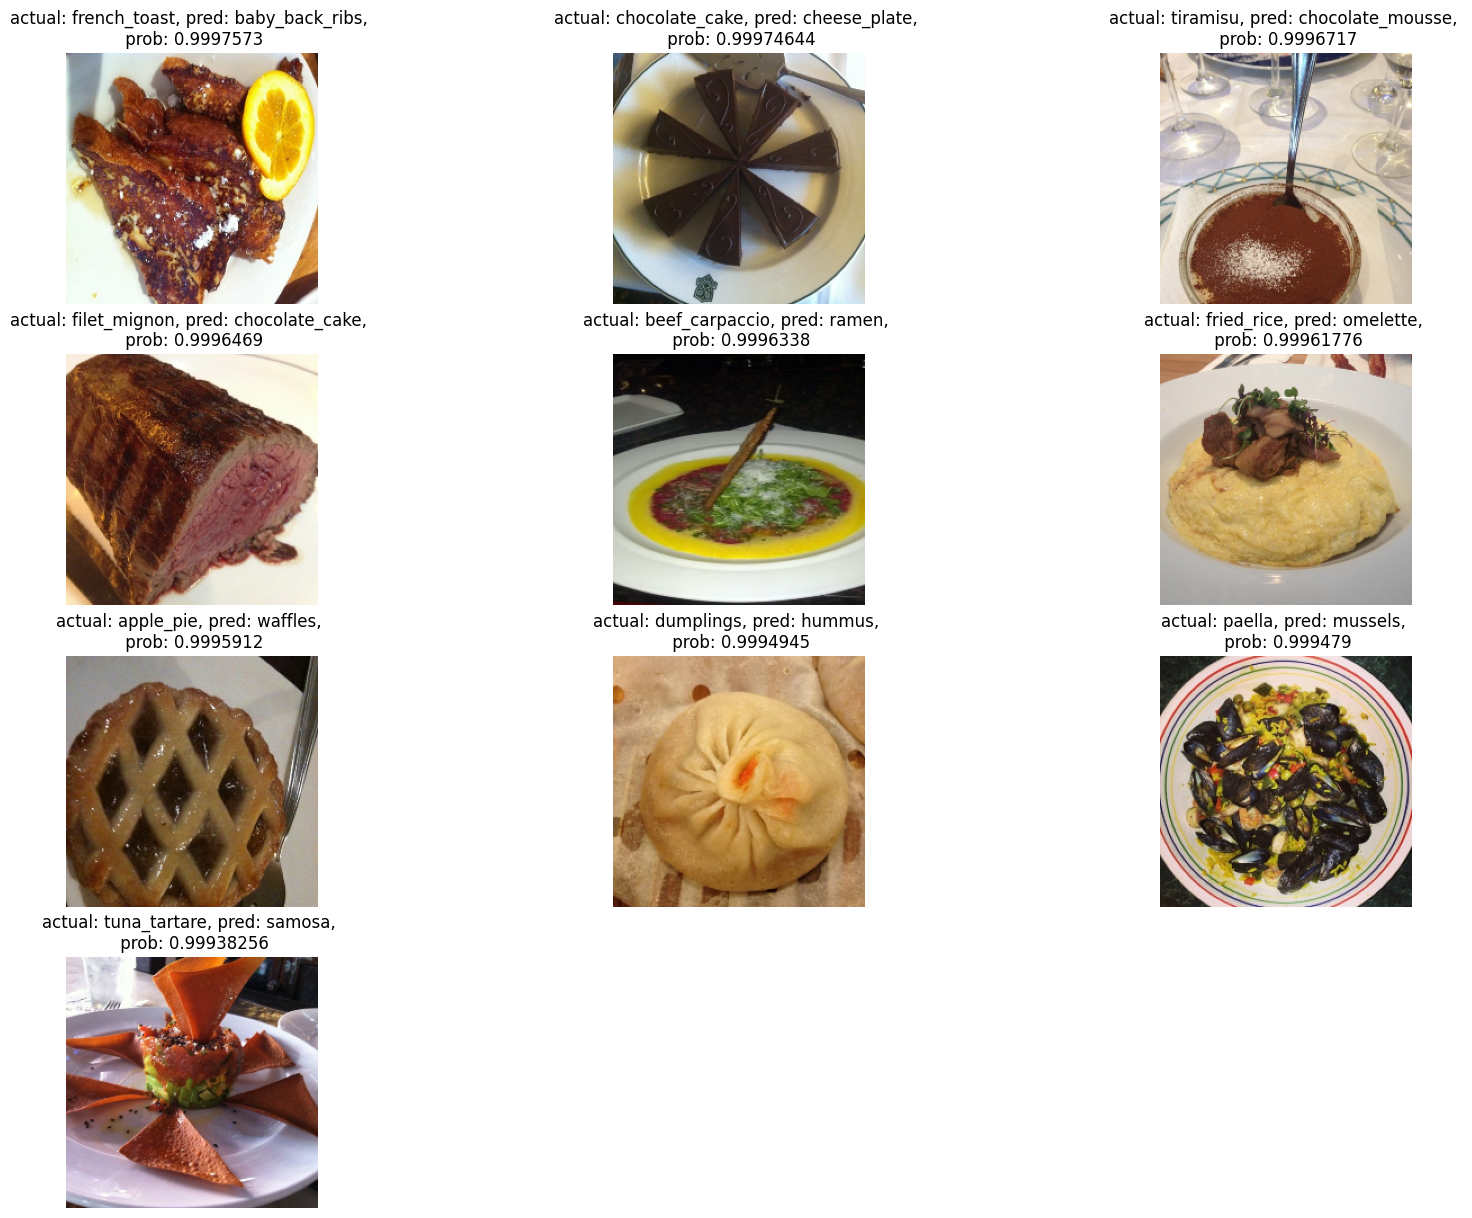

In [ ]:
# 5. Visualize the first 10 test data samples which have the wrong prediction but highest pred probability
# Make preds on a series of random images
plt.figure(figsize=(20, 15))
filepaths = []
i = 0
start_index = 20
image_to_view = 10
for filepath in preds_100_wrong["imagepath"][start_index:start_index+image_to_view]: 
  filepaths.append(filepath)
  # Load the image and make predictions
  img = load_and_prep_image(filepath, scale=False)
  pred_conf =  preds_100_wrong.loc[preds_100_wrong['imagepath'] == filepath, 'pred_conf'].iloc[0]
  pred_class = preds_100_wrong.loc[preds_100_wrong['imagepath'] == filepath, 'y_pred_classname'].iloc[0] 
  class_name = preds_100_wrong.loc[preds_100_wrong["imagepath"] == filepath, "y_true_classname"].iloc[0]

  # plot the images
  plt.subplot(4, 3, i+1)
  plt.imshow(tf.squeeze(img/255.))
  plt.title(f"actual: {class_name}, pred: {pred_class}, \n prob: {pred_conf}")
  plt.axis(False);
  i = i + 1

In [ ]:
# # Another way to do it
# images_to_view = 9
# start_index = 0
# plt.figure(figsize=(15,10))
# for i, row in enumerate(preds_100_wrong[start_index:start_index+images_to_view].itertuples()):
#   plt.subplot(3, 3, i+1)
#   img = load_and_prep_image(row[1], scale=False)
#   _, _, _, _, pred_prob, y_true_classname, y_pred_classname = row # only interested in a few parameters of each row
#   plt.imshow(img/255.)
#   plt.title(f"actual:{y_true_classname}, pred:{y_pred_classname}, prob:{pred_prob}")
#   plt.axis(False)

## Test out the big dog model on our own custom images


In [ ]:
# Create custom dir
custom_dir = "drive/MyDrive/101_classes_food/custom"

1/1 [==============================] - 0s 96ms/step


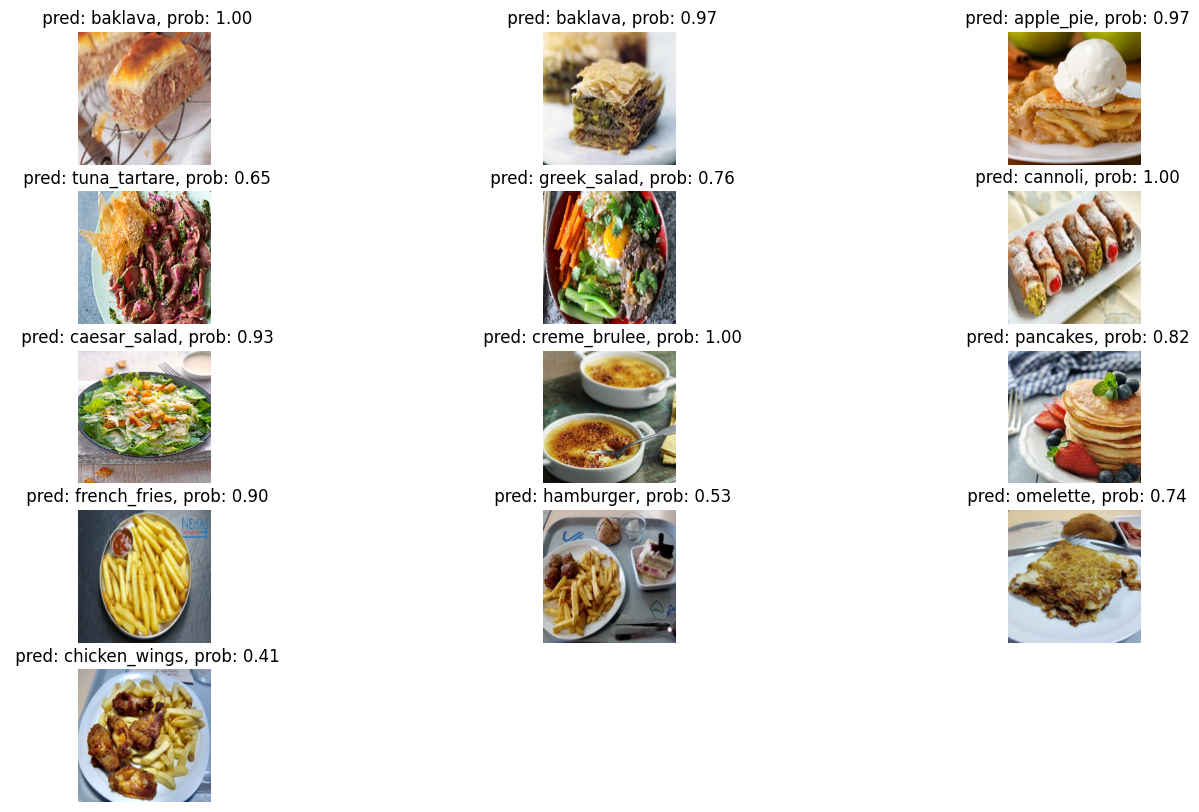

In [ ]:
plt.figure(figsize=(17, 10))
i = 0
for image in os.listdir(custom_dir): 
  # Choose a random image from a random class
  filename = image 
  filepath = custom_dir + "/" + filename

  # Load the image and make predictions
  img = load_and_prep_image(filepath, scale=False)
  pred_prob = model.predict(img) # get prediction probabilities array
  pred_class = class_names[pred_prob.argmax()] # get highest prediction probility index and match it to class_names list

  # plot the images
  plt.subplot(int(len(os.listdir(custom_dir))/3) + 1, 3, i+1)
  plt.imshow(tf.squeeze(img/255.))
  plt.title(f" pred: {pred_class}, prob: {pred_prob.max():.2f}")
  plt.axis(False);
  i = i + 1

### 🛠 06. Transfer Learning in TensorFlow Part 3: Scaling-up Exercises

1. Take 3 of your own photos of food and use the trained model to make predictions on them, share your predictions with the other students in Discord and show off your Food Vision model 🍔👁.
2. Train a feature-extraction transfer learning model for 10 epochs on the same data and compare its performance versus a model which used feature extraction for 5 epochs and fine-tuning for 5 epochs (like we've used in this notebook). Which method is better?
3. Recreate the first model (the feature extraction model) with [`mixed_precision`](https://www.tensorflow.org/guide/mixed_precision) turned on. 
  * Does it make the model train faster? 
  * Does it effect the accuracy or performance of our model? 
  * What's the advantages of using `mixed_precision` training?

In [ ]:
# Create a model with only feature-extraction for ten epochs
# Setup the base model and freeze its layers (this will extract features)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Setup model architecture with trainable top layers
inputs = layers.Input(shape=(224, 224, 3), name="input_layer")
x = data_augmentation(inputs)
x = base_model(x, training=False) # Put the base model in inference mode so weights need to stay frozen
x = layers.GlobalAveragePooling2D(name="global_avg_pool_layer")(x)
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation="softmax", name="output_layer")(x)
model_feature_extractor = tf.keras.Model(inputs, outputs)
model_fine_tuning = tf.keras.Model(inputs, outputs)

In [ ]:
# Compile the model
model_feature_extractor.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
  
# Fit the model and save its history
history_101_classes_10_epochs = model_feature_extractor.fit(train_data_all_10_percent,
                      epochs=10,
                      steps_per_epoch=len(train_data_all_10_percent),
                      validation_data=test_data,
                      validation_steps=int(0.15 * len(test_data)))

Epoch 1/10
237/237 [==============================] - 67s 242ms/step - loss: 3.3716 - accuracy: 0.2718 - val_loss: 2.4873 - val_accuracy: 0.4499
Epoch 2/10
237/237 [==============================] - 62s 261ms/step - loss: 2.2065 - accuracy: 0.4970 - val_loss: 2.0489 - val_accuracy: 0.5045
Epoch 3/10
237/237 [==============================] - 52s 217ms/step - loss: 1.8205 - accuracy: 0.5711 - val_loss: 1.8792 - val_accuracy: 0.5215
Epoch 4/10
237/237 [==============================] - 47s 196ms/step - loss: 1.6091 - accuracy: 0.6125 - val_loss: 1.7810 - val_accuracy: 0.5384
Epoch 5/10
237/237 [==============================] - 51s 210ms/step - loss: 1.4585 - accuracy: 0.6420 - val_loss: 1.7641 - val_accuracy: 0.5395
Epoch 6/10
237/237 [==============================] - 46s 191ms/step - loss: 1.3241 - accuracy: 0.6694 - val_loss: 1.7509 - val_accuracy: 0.5352
Epoch 7/10
237/237 [==============================] - 41s 170ms/step - loss: 1.2343 - accuracy: 0.6987 - val_loss: 1.7339 - val_ac

In [ ]:
results_feature_extraction_10_epochs = model_feature_extractor.evaluate(test_data)

790/790 [==============================] - 95s 120ms/step - loss: 1.5003 - accuracy: 0.5991


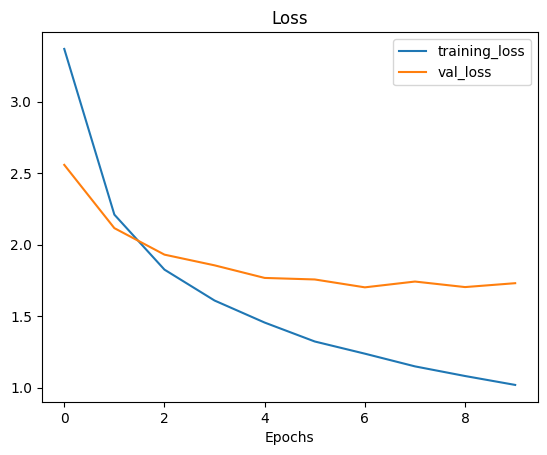

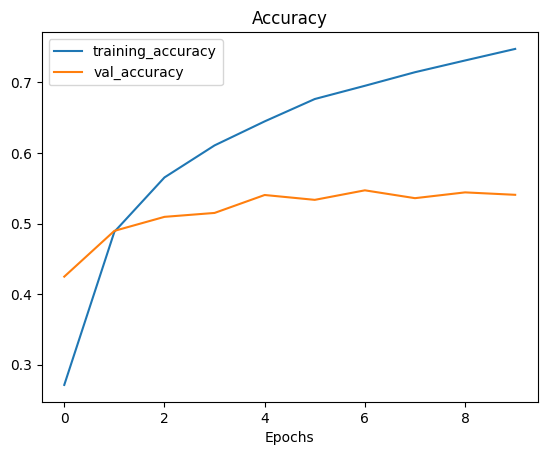

In [ ]:
plot_loss_curves(history_101_classes_10_epochs)

In [ ]:
# Compile the model
model_fine_tuning.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
  
# Fit the model and save its history
history_101_classes_5_epochs = model_fine_tuning.fit(train_data_all_10_percent,
                      epochs=5,
                      steps_per_epoch=len(train_data_all_10_percent),
                      validation_data=test_data,
                      validation_steps=int(0.15 * len(test_data)),
                      callbacks=[create_checkpoint()])

Epoch 1/5
237/237 [==============================] - 50s 170ms/step - loss: 0.9752 - accuracy: 0.7551 - val_loss: 1.6752 - val_accuracy: 0.5569
Epoch 2/5
237/237 [==============================] - 36s 149ms/step - loss: 0.8972 - accuracy: 0.7814 - val_loss: 1.7155 - val_accuracy: 0.5474
Epoch 3/5
237/237 [==============================] - 38s 158ms/step - loss: 0.8418 - accuracy: 0.8000 - val_loss: 1.6868 - val_accuracy: 0.5535
Epoch 4/5
237/237 [==============================] - 39s 161ms/step - loss: 0.8022 - accuracy: 0.8049 - val_loss: 1.7204 - val_accuracy: 0.5463
Epoch 5/5
237/237 [==============================] - 36s 151ms/step - loss: 0.7570 - accuracy: 0.8210 - val_loss: 1.7082 - val_accuracy: 0.5477


In [ ]:
# Unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze every layers except the last 5
for layer in base_model.layers[:-5]:
  layer.trainable=False

In [ ]:
# Compile the model
model_fine_tuning.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=["accuracy"])

In [ ]:
initial_epoch = 5

In [ ]:
fine_tune_epochs = initial_epoch + 5
history_fine_101_classes_fine_5_epochs = model_fine_tuning.fit(train_data_all_10_percent,
                                                         epochs=fine_tune_epochs,
                                                         validation_data=test_data,
                                                         validation_steps=int(0.15 * len(test_data)),
                                                         initial_epoch=history_101_classes_5_epochs.epoch[-1]) #Start training from previous last epoch

Epoch 5/10
237/237 [==============================] - 56s 168ms/step - loss: 0.6430 - accuracy: 0.8289 - val_loss: 1.8183 - val_accuracy: 0.5426
Epoch 6/10
237/237 [==============================] - 46s 194ms/step - loss: 0.5734 - accuracy: 0.8437 - val_loss: 1.8724 - val_accuracy: 0.5421
Epoch 7/10
237/237 [==============================] - 37s 153ms/step - loss: 0.5167 - accuracy: 0.8580 - val_loss: 1.9174 - val_accuracy: 0.5339
Epoch 8/10
237/237 [==============================] - 35s 144ms/step - loss: 0.4666 - accuracy: 0.8767 - val_loss: 1.9165 - val_accuracy: 0.5384
Epoch 9/10
237/237 [==============================] - 37s 155ms/step - loss: 0.4403 - accuracy: 0.8824 - val_loss: 1.9077 - val_accuracy: 0.5413
Epoch 10/10
237/237 [==============================] - 35s 145ms/step - loss: 0.4057 - accuracy: 0.8948 - val_loss: 1.9399 - val_accuracy: 0.5381


In [ ]:
results_fine_tuning = model_fine_tuning.evaluate(test_data)

790/790 [==============================] - 82s 100ms/step - loss: 1.5022 - accuracy: 0.5948


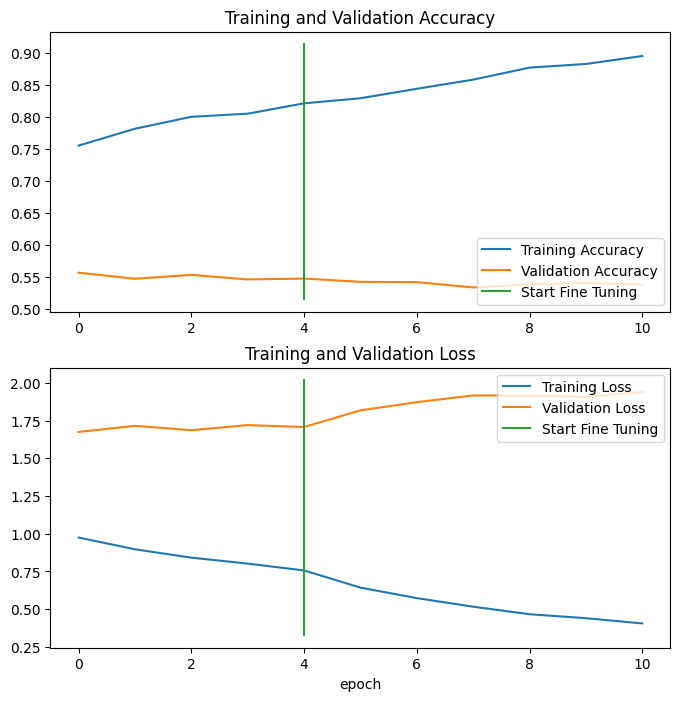

In [ ]:
compare_historys(history_101_classes_5_epochs,
                 history_fine_101_classes_fine_5_epochs,
                 initial_epoch)

In [ ]:
# # Séparer les couches dense et softmax pour une meilleur stabilité sur float32
# x = layers.Dense(len(train_data_all_10_percent.class_names), name='dense_logits')(x)
# outputs = layers.Activation('softmax', dtype='float32', name='predictions')(x)
# # Au lieu de
# outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation="softmax", name="output_layer")(x)

In [ ]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

In [ ]:
# Create a model with only feature-extraction for ten epochs
# Setup the base model and freeze its layers (this will extract features)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Setup model architecture with trainable top layers
inputs = layers.Input(shape=(224, 224, 3), name="input_layer")
x = data_augmentation(inputs)
x = base_model(x, training=False) # Put the base model in inference mode so weights need to stay frozen
x = layers.GlobalAveragePooling2D(name="global_avg_pool_layer")(x)
x = layers.Dense(len(train_data_all_10_percent.class_names), name='dense_logits')(x)
outputs = layers.Activation('softmax', dtype='float32', name='predictions')(x)
model_feature_extractor = tf.keras.Model(inputs, outputs)
model_fine_tuning = tf.keras.Model(inputs, outputs)

In [ ]:
# Compile the model
model_feature_extractor.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
  
# Fit the model and save its history
history_101_classes_10_epochs = model_feature_extractor.fit(train_data_all_10_percent,
                      epochs=10,
                      steps_per_epoch=len(train_data_all_10_percent),
                      validation_data=test_data,
                      validation_steps=int(0.15 * len(test_data)))

Epoch 1/10
237/237 [==============================] - 119s 460ms/step - loss: 3.3759 - accuracy: 0.2722 - val_loss: 2.4935 - val_accuracy: 0.4423
Epoch 2/10
237/237 [==============================] - 85s 355ms/step - loss: 2.1929 - accuracy: 0.4939 - val_loss: 2.0981 - val_accuracy: 0.4876
Epoch 3/10
237/237 [==============================] - 71s 295ms/step - loss: 1.8273 - accuracy: 0.5613 - val_loss: 1.9028 - val_accuracy: 0.5164
Epoch 4/10
237/237 [==============================] - 75s 316ms/step - loss: 1.6037 - accuracy: 0.6086 - val_loss: 1.8429 - val_accuracy: 0.5265
Epoch 5/10
237/237 [==============================] - 66s 275ms/step - loss: 1.4509 - accuracy: 0.6453 - val_loss: 1.7914 - val_accuracy: 0.5307
Epoch 6/10
237/237 [==============================] - 61s 257ms/step - loss: 1.3417 - accuracy: 0.6644 - val_loss: 1.7982 - val_accuracy: 0.5262
Epoch 7/10
237/237 [==============================] - 61s 255ms/step - loss: 1.2291 - accuracy: 0.6970 - val_loss: 1.7551 - val_a

In [ ]:
results_feature_extraction_10_epochs_mixed_precision = model_feature_extractor.evaluate(test_data)

790/790 [==============================] - 77s 97ms/step - loss: 1.5022 - accuracy: 0.5948


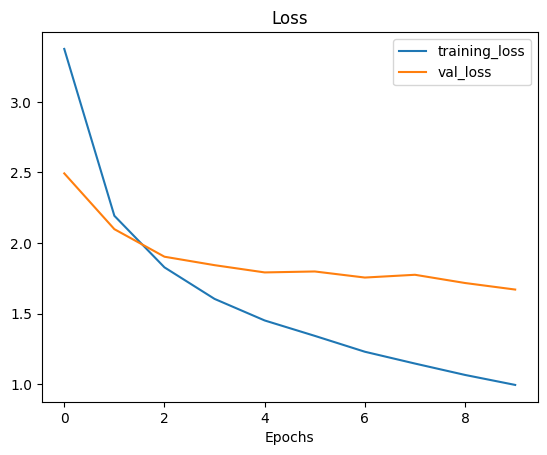

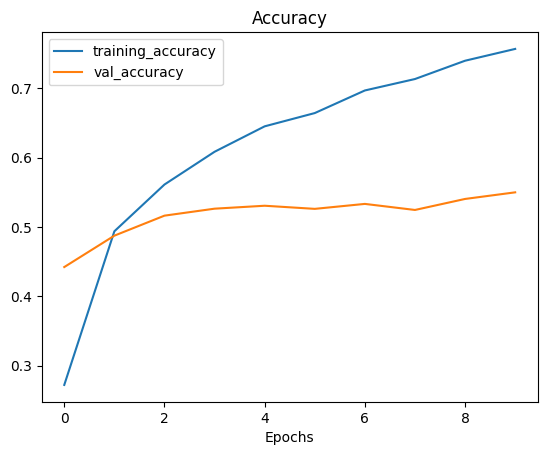

In [ ]:
plot_loss_curves(history_101_classes_10_epochs)

### 📖 06. Transfer Learning in TensorFlow Part 3: Scaling-up Extra-curriculum
* Spend 15-minutes reading up on the [EarlyStopping callback](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping). What does it do? How could we use it in our model training?
* Spend an hour reading about [Streamlit](https://www.streamlit.io/). What does it do? How might you integrate some of the things we've done in this notebook in a Streamlit app?
